# Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

Обучающая и тестовая выборка состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа изображенного на ней. Тест был поделен на приватную и публичную часть в соотношении 95/5

В тренировочном датасете примерно по 1000 картинок на каждый класс, но они отличаются размером.

Важный момент: метки классов представлены в виде названий папок, в которых лежат картинки. Это сделано для того, чтобы вы могли без проблем использовать библиотечные загрузчики данных, а не писали свои, тратя на это весь свой последний(единственный) день, который вы отвели на задание :)



### Описание файлов
- train.csv - the training set
- testset.csv - the test set
- sampleSubmission.csv - пример решения, если у вас нет времени на задание

### Поля в данных
- image_id - id картинки
- Expected - имя персонажа

### Цель:
Получить качественный классификатор изображений на 42 класса, ключевая метрика - F1

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd
import seaborn as sns

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA is available!  Training on GPU ...


Зададим константы, которыми будем пользоваться

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
N_CORES = 2
BATCH_SIZE = 64 #128
RESCALE_SIZE = 224
EPOCHS = 10

Зададим процессор, который нам доступен

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
!ls /kaggle/input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [5]:
# проверка существующих классов
!ls /kaggle/input/journey-springfield/train/simpsons_dataset

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov  7 22:01:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
import math
import random
from skimage import io
import os
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from multiprocessing.pool import ThreadPool
import torch.optim as optim

from typing import Dict

import torch


from collections import Counter

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Этот код выполняет следующие действия:

1. Определяет две переменные `TRAIN_DIR` и `TEST_DIR`, которые содержат пути к директориям с данными обучения и тестирования соответственно. `Path` - это объект из библиотеки `pathlib`, который представляет путь к файлу или директории в операционной системе.

2. `train_val_files` создает список файлов обучающего набора данных, ищет все файлы с расширением `.jpg` внутри директории `TRAIN_DIR` и ее поддиректориях (рекурсивно). Затем список сортируется в алфавитном порядке.

3. `test_files` аналогично создает список файлов тестового набора данных, на этот раз в директории `TEST_DIR`.

В результате, после выполнения этого кода, `train_val_files` будет содержать список путей к изображениям обучающего набора, а `test_files` - список путей к изображениям тестового набора. Эти списки могут быть использованы для дальнейшей загрузки данных, обучения моделей и выполнения других операций.

In [9]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
train_val_files[0:5]

[PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

Создаем список лейблов

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]

Этот код определяет функцию `load_image`, которая выполняет следующие действия:

1. Принимает входной аргумент `file`, который представляет путь к файлу изображения.

2. Открывает изображение с помощью `Image.open(file)`. `Image` здесь представляет класс из библиотеки Pillow (PIL), используемой для работы с изображениями.

3. Метод `.load()` вызывается для того, чтобы фактически загрузить содержимое изображения. Это может быть полезно, если вам нужно, чтобы вся информация об изображении была доступна в оперативной памяти, например, перед обработкой или аугментацией.

4. Возвращает объект изображения.

Таким образом, эта функция загружает изображение из файла, гарантируя, что оно полностью загружено и доступно для дальнейшей обработки или использования.

In [12]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

Посчитаем кол-ва изображений в каждом классе, создаем агрегированную таблицу

In [13]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [14]:
data = get_count(train_val_labels)

Этот код определяет функцию `show_data`, которая использует библиотеки `matplotlib` и `seaborn` для визуализации данных в виде столбчатой диаграммы:

1. Принимает входной аргумент `data`, который представляет собой набор данных (вероятно, DataFrame или подобную структуру), содержащий информацию для отображения на диаграмме.

2. `min_level` и `max_level` - это опциональные параметры, которые контролируют, будут ли на диаграмме отображаться горизонтальные линии, обозначающие минимальный и максимальный уровни.

3. Создает новую фигуру (рисунок) с помощью `plt.figure(figsize=(15, 9))`, задавая размеры фигуры в дюймах.

4. С помощью `sns.barplot` создает столбчатую диаграмму, где по оси X будут размещены значения `data.index` (вероятно, это категориальные метки), а по оси Y - значения из столбца `'count'` данных `data`.

5. `orient='v'` указывает, что диаграмма должна быть вертикальной.

6. `.set_xticklabels(data.index, rotation=90)` устанавливает подписи по оси X, используя метки `data.index`, и поворачивает их на 90 градусов для лучшей читаемости.

7. Если `max_level` истинно, добавляется горизонтальная линия (`plt.axhline(y=1500)`), чтобы отметить максимальный уровень на диаграмме. 

8. Если `min_level` истинно, добавляется красная горизонтальная линия (`plt.axhline(y=100, color='red')`), чтобы отметить минимальный уровень на диаграмме.

9. `plt.show()` отображает созданную диаграмму.

Эта функция помогает визуализировать данные в виде столбчатой диаграммы с дополнительными горизонтальными линиями для обозначения определенных уровней.

In [15]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    plt.show()

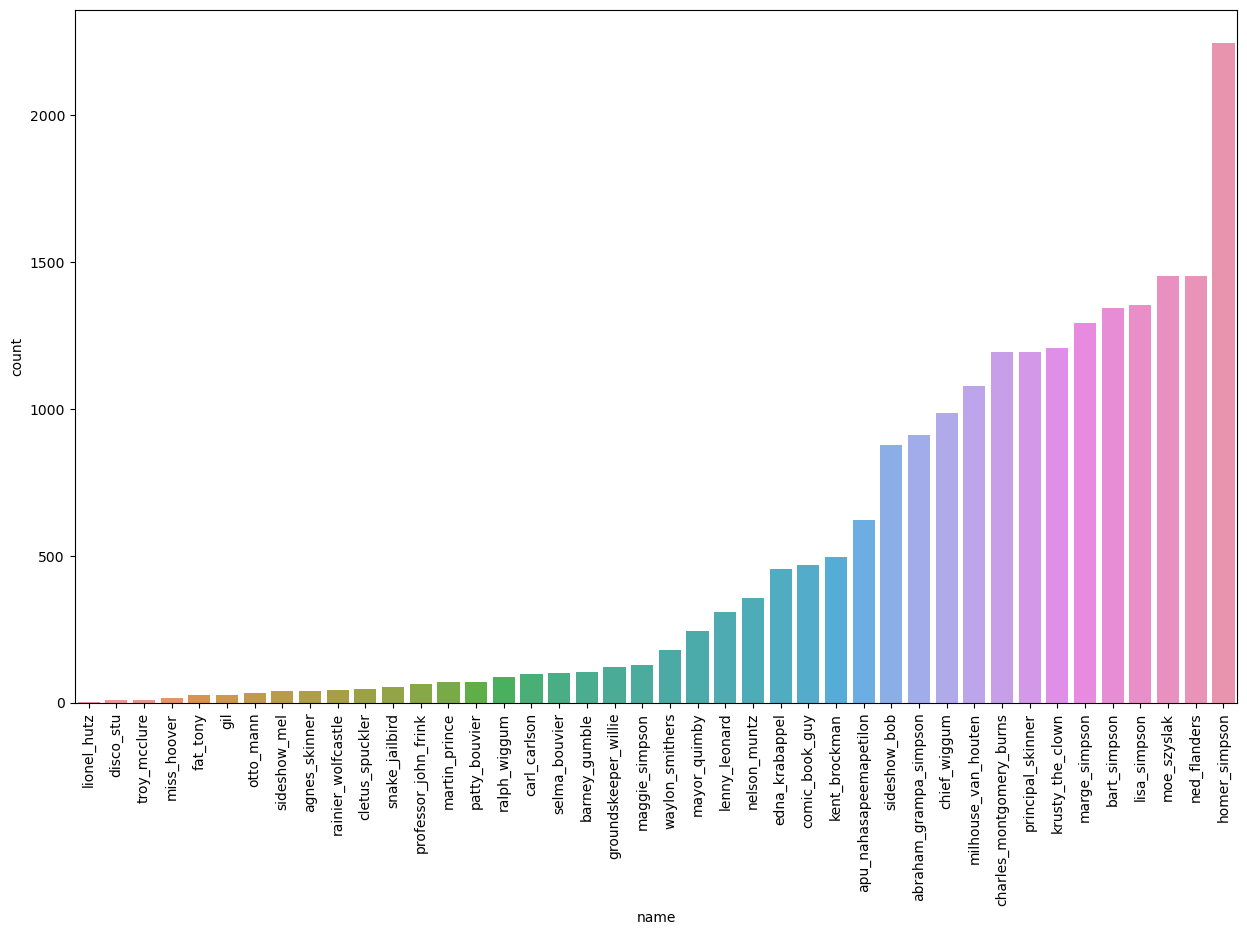

In [16]:
show_data(data)

In [17]:
len(train_val_files)

20933

In [18]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_val_data = get_count(train_val_labels)

Делим датасет на тренировочную и валидационную

In [19]:
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [20]:
len(train_files)

16746

Пока train_files, val_files у нас содержат только список путей к изображениям. Нужно сделать из них датасеты. Для этого создадим класс SimpsonsDataset

Код определяет пользовательский класс датасета для работы с изображениями в задаче классификации персонажей "Симпсонов". Разберем каждую часть класса по порядку:

1. `class SimpsonsDataset(Dataset):` - Определение класса наследующего от `torch.utils.data.Dataset`, что позволяет использовать этот класс внутри PyTorch для работы с данными.

2. `def __init__(self, files, mode):` - Метод-конструктор класса. Он принимает список файлов `files` и режим работы `mode` (один из элементов списка `DATA_MODES`, предполагается, что это либо `'train'`, `'val'` или `'test'`).

3. Внутри конструктора:
   - `self.files = sorted(files)` - Сохраняет список файлов для загрузки изображений и сортирует их.
   - `self.mode = mode` - Сохраняет режим работы датасета.
   - `self.len_ = len(self.files)` - Сохраняет количество файлов в датасете.

4. `def __len__(self):` - Метод, возвращающий длину (количество образцов) датасета.

5. `def load_sample(self, file):` - Метод, загружающий изображение из файла с помощью библиотеки `PIL` (Python Imaging Library).

6. `def __getitem__(self, index):` - Метод, возвращающий образец из датасета по заданному индексу.
   - `transform = transforms.Compose([...])` - Создает цепочку преобразований для изображения, включая преобразование в тензор и нормализацию.
   - `x = self.load_sample(self.files[index])` - Загружает изображение.
   - `x = self._prepare_sample(x)` - Применяет метод `_prepare_sample()` для изменения размера изображения.
   - `x = np.array(x / 255, dtype='float32')` - Преобразует изображение в массив NumPy и выполняет нормирование путем деления на 255.
   - `x = transform(x)` - Применяет определенные ранее преобразования.
   - Если режим датасета не `'test'`, то выполняется следующее:
     - `label = self.labels[index]` - Получает метку (имя папки, соответствующей классу персонажа) для данного изображения.
     - `label_id = self.label_encoder.transform([label])` - Преобразует метку в числовое значение, используя кодировщик меток.
     - `y = label_id.item()` - Преобразует числовое значение метки в скалярное значение Python.
     - Возвращает обработанное изображение и соответствующую метку класса.
   - Если режим датасета `'test'`, возвращает только обработанное изображение.

7. `def _prepare_sample(self, image):` - Внутренний метод для изменения размера изображения:
   - `image = image.resize((RESCALE_SIZE, RESCALE_SIZE))` - Изменяет размер изображения на заданный.
   - Возвращает измененное изображение в виде массива NumPy.

Общий результат - класс `SimpsonsDataset`, который позволяет загружать и обрабатывать изображения, подготавливая их для использования в моделях машинного обучения с помощью библиотеки PyTorch.

`with open('label_encoder.pkl', 'wb') as le_dump_file:

                  pickle.dump(self.label_encoder, le_dump_file)`
выполняет сохранение объекта `self.label_encoder` в файл с именем `'label_encoder.pkl'` с использованием модуля `pickle`. Здесь происходит сериализация (преобразование объекта Python в байтовую последовательность) объекта `self.label_encoder` и его запись в файл в двоичном режиме (`'wb'`).

Сериализация позволяет сохранить состояние объекта между сеансами выполнения программы. В данном случае, `self.label_encoder` - это объект кодировщика меток (LabelEncoder), который используется для преобразования строковых меток классов в числовые значения. Сохранение этого объекта позволит в будущем восстановить точно такой же объект кодировщика меток при загрузке модели для инференса (прогнозирования) на новых данных.

In [21]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)



In [22]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [23]:
val_dataset = SimpsonsDataset(val_files, mode='val')

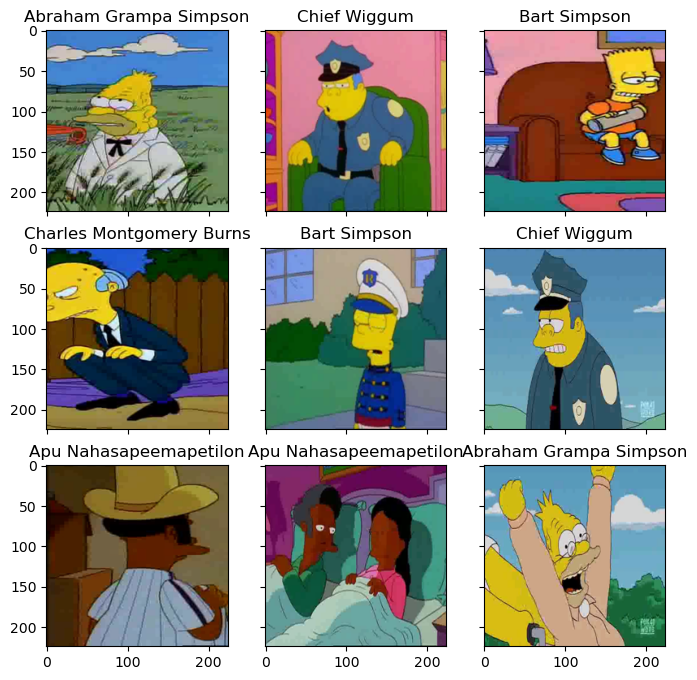

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Загрузка модели и обучение

Загружаем предобученную модель efficientnet_b2. Меняем классификатор, добавив 2 линейных слоя  с активациями и батчнормом

In [25]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)
optimizer = torch.optim.Adam(efficientnet_b2.parameters(), lr=0.0003)

efficientnet_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 197MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Функция для обучения одной эпохи

In [26]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train(True) #добавлено для оптимизации

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    if sheduler is not None: #добавлено для оптимизации
        sheduler.step(train_loss) #добавлено для оптимизации
    return train_loss, train_acc

Функция для валидации на 1 эпохе

In [27]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Функция для тренировки на всех эпохах 

In [28]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, sheduler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Функция для предсказания 

In [29]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [30]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

Задаем оптимизатор и scheduler

In [31]:
optimizer = optim.AdamW(efficientnet_b2.parameters(), lr=0.0003, weight_decay=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

**Обучение модели**

In [32]:
%%time
#history = train(train_dataset, val_dataset, model=efficientnet_b2, epochs=EPOCHS, batch_size=BATCH_SIZE)
history = train(train_dataset, val_dataset, model=efficientnet_b2, epochs=10,
                       batch_size=BATCH_SIZE, optimizer=optimizer, sheduler=scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.734225692491541


epoch:  10%|█         | 1/10 [02:32<22:48, 152.02s/it]


Epoch 001 train_loss: 0.7342     val_loss 0.1974 train_acc 0.8533 val_acc 0.9549
loss 0.13057280584473943


epoch:  20%|██        | 2/10 [05:00<19:58, 149.82s/it]


Epoch 002 train_loss: 0.1306     val_loss 0.1196 train_acc 0.9738 val_acc 0.9737
loss 0.049927110817680705


epoch:  30%|███       | 3/10 [07:28<17:24, 149.19s/it]


Epoch 003 train_loss: 0.0499     val_loss 0.1250 train_acc 0.9910 val_acc 0.9690
loss 0.033851407520263


epoch:  40%|████      | 4/10 [09:56<14:52, 148.73s/it]


Epoch 004 train_loss: 0.0339     val_loss 0.1097 train_acc 0.9930 val_acc 0.9749
loss 0.030481966823485394


epoch:  50%|█████     | 5/10 [12:24<12:22, 148.44s/it]


Epoch 005 train_loss: 0.0305     val_loss 0.1114 train_acc 0.9925 val_acc 0.9759
loss 0.023460367356693854


epoch:  60%|██████    | 6/10 [14:53<09:54, 148.60s/it]


Epoch 006 train_loss: 0.0235     val_loss 0.1208 train_acc 0.9949 val_acc 0.9730
loss 0.028505443950949727


epoch:  70%|███████   | 7/10 [17:21<07:25, 148.37s/it]


Epoch 007 train_loss: 0.0285     val_loss 0.1463 train_acc 0.9930 val_acc 0.9666
loss 0.022243663426597643


epoch:  80%|████████  | 8/10 [19:49<04:56, 148.29s/it]


Epoch 008 train_loss: 0.0222     val_loss 0.1289 train_acc 0.9940 val_acc 0.9735
loss 0.015426209259404087


epoch:  90%|█████████ | 9/10 [22:18<02:28, 148.58s/it]


Epoch 009 train_loss: 0.0154     val_loss 0.1120 train_acc 0.9958 val_acc 0.9780
loss 0.013662406693306232


epoch: 100%|██████████| 10/10 [24:47<00:00, 148.74s/it]


Epoch 010 train_loss: 0.0137     val_loss 0.1092 train_acc 0.9960 val_acc 0.9766
CPU times: user 21min, sys: 1min 55s, total: 22min 55s
Wall time: 24min 47s


In [33]:
loss, acc, val_loss, val_acc = zip(*history) 

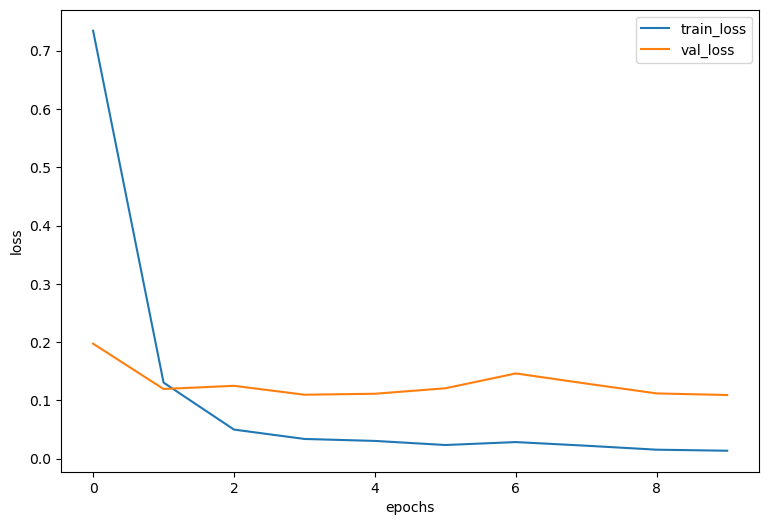

In [34]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

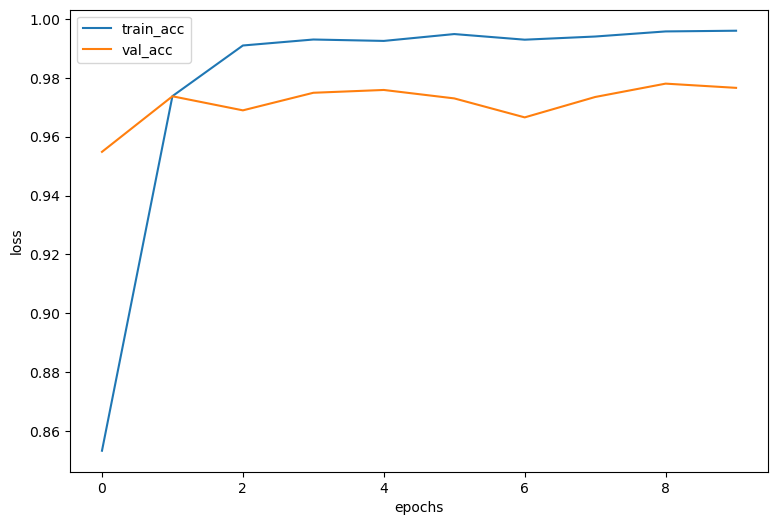

In [35]:
plt.figure(figsize=(9, 6))
plt.plot([item for item in acc], label="train_acc")
plt.plot([item.cpu() for item in val_acc], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [36]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [37]:
random_characters = int(np.random.uniform(0,len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(efficientnet_b2, ex_img.unsqueeze(0))

In [38]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(efficientnet_b2, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
list(y_pred)

[17, 25, 25, 20, 25, 20, 25, 27, 6, 4, 2, 15, 18, 22, 37, 15, 27, 20, 7, 22]

In [42]:
idxs

[1909,
 2825,
 2878,
 3661,
 2784,
 2353,
 2974,
 3144,
 778,
 459,
 313,
 1566,
 2085,
 2577,
 4011,
 1385,
 3185,
 2224,
 921,
 2576]

In [43]:
actual_labels

[17, 25, 25, 32, 25, 20, 25, 27, 6, 4, 2, 15, 18, 22, 37, 15, 27, 20, 7, 22]

In [44]:
preds_class

['krusty_the_clown',
 'milhouse_van_houten',
 'milhouse_van_houten',
 'lisa_simpson',
 'milhouse_van_houten',
 'lisa_simpson',
 'milhouse_van_houten',
 'moe_szyslak',
 'charles_montgomery_burns',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'homer_simpson',
 'lenny_leonard',
 'marge_simpson',
 'sideshow_bob',
 'homer_simpson',
 'moe_szyslak',
 'lisa_simpson',
 'chief_wiggum',
 'marge_simpson']

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [45]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="micro")

0.9500000000000001

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(efficientnet_b2, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [47]:
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [48]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [49]:
my_submit.to_csv('efficientnet_b2.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [50]:
torch.save(efficientnet_b2, 'efficientnet_b2.pth')

**Вывод:**
- Предобработка данных:
    - Был сильный дисбаланс классов,поэтому сделали аугментацию данных, чтобы увеличить кол-во маленьких классов
- Была выбрана и обучена модель `EfficientNet_b2` для классифакация изображений персонажей Симпсонов на 42 класса:
    - Была взята предобученная на данных ImageNet модель. Заменили классификтор на пользовательский, который классифицирует на 42 класса
    - Получили accuracy на валидацинной выборке `0.99`
    - Целевой метрикой соревнования была метрика f1.  Получили на публичном тесте значение `f1 = 0.99256`

**Благодарности:**

MAXIM USTINOV https://www.kaggle.com/code/maximustinov/maxim-ustinov2022

MARINA LAKEEVA за код с аугментацией
https://www.kaggle.com/code/marinalakeeva/data-augmentation